In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.0.1+cu117)
    Python  3.9.18 (you have 3.9.17)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Loading in data and pretrained model

In [2]:
timm.list_models("vit*",pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai

In [3]:
batch_size=24
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch16_224.orig_in21k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224,224)),
                                                torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.ImageFolder("./data/train",transform=transforms)
test_data=torchvision.datasets.ImageFolder("./data/test",transform=transforms)

train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

##### Freezing layers

In [4]:
count=0
for param in model.parameters(): #152 params
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

##### Model Modification

In [5]:
#Changing the classification part
model.head=nn.Linear(in_features=model.head.in_features,out_features=1024)

class modified_vit(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
        self.sequential=nn.Sequential(nn.Linear(in_features=1024,out_features=2048),
                                      nn.ReLU(),
                                      nn.Linear(in_features=2048,out_features=512),
                                      nn.ReLU(),
                                      nn.Linear(in_features=512,out_features=256),
                                      nn.ReLU(),
                                      nn.Linear(in_features=256,out_features=128),
                                      nn.ReLU(),
                                      nn.Linear(in_features=128,out_features=2))
    def forward(self,x):
        return self.sequential(self.model(x))

In [6]:
model=modified_vit(model)
model=model.to(device)

In [7]:
summary(model)

Layer (type:depth-idx)                        Param #
modified_vit                                  --
├─VisionTransformer: 1-1                      152,064
│    └─PatchEmbed: 2-1                        --
│    │    └─Conv2d: 3-1                       (590,592)
│    │    └─Identity: 3-2                     --
│    └─Dropout: 2-2                           --
│    └─Identity: 2-3                          --
│    └─Identity: 2-4                          --
│    └─Sequential: 2-5                        --
│    │    └─Block: 3-3                        (7,087,872)
│    │    └─Block: 3-4                        (7,087,872)
│    │    └─Block: 3-5                        (7,087,872)
│    │    └─Block: 3-6                        (7,087,872)
│    │    └─Block: 3-7                        (7,087,872)
│    │    └─Block: 3-8                        (7,087,872)
│    │    └─Block: 3-9                        (7,087,872)
│    │    └─Block: 3-10                       (7,087,872)
│    │    └─Block: 3-11      

In [8]:
model

modified_vit(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')

### Visualizing Transformed Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


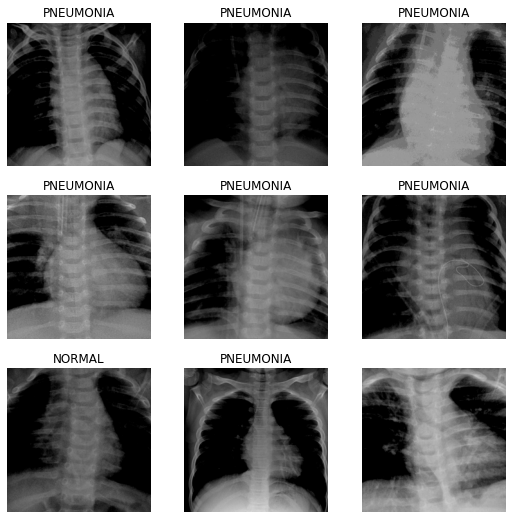

In [9]:
plt.figure(figsize=(9,9))
for i in range(1,10):
    data=next(iter(train_loader))
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.title(train_data.classes[label.item()])
    plt.subplot(3,3,i)
    plt.axis(False)
    plt.imshow(image)
    

### Optimizer and Loss and Logdir

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [11]:
log_dir = "./"+model_name+"feature_extractor_tensorboard"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing model

In [12]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[ 0.0222, -0.0249],
        [ 0.0212, -0.0246],
        [ 0.0219, -0.0252],
        [ 0.0195, -0.0250],
        [ 0.0239, -0.0268],
        [ 0.0243, -0.0218],
        [ 0.0257, -0.0239],
        [ 0.0248, -0.0265],
        [ 0.0228, -0.0247],
        [ 0.0239, -0.0241],
        [ 0.0246, -0.0220],
        [ 0.0247, -0.0224],
        [ 0.0245, -0.0255],
        [ 0.0274, -0.0222],
        [ 0.0255, -0.0224],
        [ 0.0245, -0.0265],
        [ 0.0251, -0.0245],
        [ 0.0272, -0.0292],
        [ 0.0270, -0.0275],
        [ 0.0254, -0.0217],
        [ 0.0248, -0.0263],
        [ 0.0246, -0.0269],
        [ 0.0217, -0.0241],
        [ 0.0225, -0.0252]], device='cuda:0')
tensor(0.7050, device='cuda:0')
0.25


### Training Loop

In [13]:
epochs=10

train_accuracy=[]
test_accuracy=[]
train_loss=[]
test_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and test data
    temp_train_accuracy=[]
    temp_test_accuracy=[]
    temp_train_loss=[]
    temp_test_loss=[]

    net_train_accuracy=0
    net_test_accuracy=0
    net_train_loss=0
    net_test_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing:")
    model.eval()

    with tqdm(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
    test_accuracy.append(net_test_accuracy)
    test_loss.append(net_test_loss)
    writer.add_scalar("Test Accuracy",net_test_accuracy,i)
    writer.add_scalar("Test Loss",net_test_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Test Accuracy: {net_test_accuracy}  Test Loss: {net_test_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.89799635701275  Train Loss: 0.27162095306020057  Test Accuracy: 0.8766393442622953  Test Loss: 0.23628842452021895


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9510473588342442  Train Loss: 0.14989540275361876  Test Accuracy: 0.9636612021857927  Test Loss: 0.09956506732851267


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.956739526411658  Train Loss: 0.15398054181463264  Test Accuracy: 0.9486338797814209  Test Loss: 0.16071879422505858


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9644808743169402  Train Loss: 0.09899060779010693  Test Accuracy: 0.9633879781420768  Test Loss: 0.10962470741866187


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9713114754098364  Train Loss: 0.10445400866963044  Test Accuracy: 0.9587431693989072  Test Loss: 0.12345351123815922


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 0.9640255009107477  Train Loss: 0.11343949900550737  Test Accuracy: 0.9672131147540985  Test Loss: 0.15388736843329962


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 0.9719945355191265  Train Loss: 0.08480433185834213  Test Accuracy: 0.967896174863388  Test Loss: 0.12682724277752253


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8:
Train Accuracy: 0.9831511839708563  Train Loss: 0.05085392971425696  Test Accuracy: 0.96448087431694  Test Loss: 0.11629005407792378


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9:
Train Accuracy: 0.9826958105646628  Train Loss: 0.05315702501398657  Test Accuracy: 0.9562841530054647  Test Loss: 0.14176435260766293


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10:
Train Accuracy: 0.9822404371584705  Train Loss: 0.05637165244010387  Test Accuracy: 0.9542349726775959  Test Loss: 0.1727536043923226


